In [1]:
import gc
import tensorflow as tf

gc.collect()
tf.keras.backend.clear_session()


In [2]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import os


# Paths
dataset_path = "/kaggle/input/intel-image-classification"
train_dir = os.path.join(dataset_path, "seg_train", "seg_train")
val_dir   = os.path.join(dataset_path, "seg_test", "seg_test")
pred_dir  = os.path.join(dataset_path, "seg_pred", "seg_pred")


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# =============================
# ✅ Updated Parameters
# =============================
IMG_SIZE = (224, 224)
BATCH_SIZE = 8
weight_decay = 1e-4
layer_scale_init_value = 1e-6
dims = [96, 192, 384, 768]
depths = [3, 6, 9, 3]
max_drop_path_rate = 0.2

In [5]:
# =============================
# ✅ Custom Stochastic Depth Layer
# =============================
class StochasticDepth(tf.keras.layers.Layer):
    def __init__(self, survival_prob=1.0, **kwargs):
        super(StochasticDepth, self).__init__(**kwargs)
        self.survival_prob = survival_prob

    def call(self, x, training=None):
        if (not training) or (self.survival_prob == 1.0):
            return x

        batch_size = tf.shape(x)[0]
        random_tensor = self.survival_prob + tf.random.uniform([batch_size, 1, 1, 1], dtype=x.dtype)
        binary_tensor = tf.floor(random_tensor)
        return x / self.survival_prob * binary_tensor

    def get_config(self):
        config = super().get_config()
        config.update({"survival_prob": self.survival_prob})
        return config

In [6]:
# =============================
# ✅ Dataset Loaders (Integrated)
# =============================
# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Validation Dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Prediction Dataset
pred_ds = tf.keras.preprocessing.image_dataset_from_directory(
    pred_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    label_mode=None
)

# =============================
# ✅ Normalization & Prefetch
# =============================
normalization = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization(x), y)).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.map(lambda x, y: (normalization(x), y)).prefetch(tf.data.AUTOTUNE)
pred_ds  = pred_ds.map(lambda x: normalization(x)).prefetch(tf.data.AUTOTUNE)


Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
Found 7301 files.


In [7]:


# =============================
# ✅ Augmentation
# =============================
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
    layers.RandomTranslation(0.1, 0.1),
])

In [8]:
# =============================
# ✅ ConvNeXt Block with DropPath
# =============================
class ConvNext_Block(tf.keras.Model):
    def __init__(self, dim, drop_path_rate=0.0, layer_scale_init_value=1e-6, **kwargs):
        super().__init__(**kwargs)
        self.depthwise_conv = layers.Conv2D(dim, kernel_size=7, padding="same", groups=dim,
                                            kernel_regularizer=tf.keras.regularizers.l2(weight_decay))
        self.norm = layers.LayerNormalization(epsilon=1e-6)
        self.pw_conv1 = layers.Dense(4 * dim, kernel_regularizer=tf.keras.regularizers.l2(weight_decay))
        self.act = layers.Activation("gelu")
        self.pw_conv2 = layers.Dense(dim, kernel_regularizer=tf.keras.regularizers.l2(weight_decay))
        self.gamma = tf.Variable(layer_scale_init_value * tf.ones((dim,)), trainable=True)
        self.drop_path = StochasticDepth(survival_prob=1.0 - drop_path_rate)

    def call(self, inputs, training=None):
        x = self.depthwise_conv(inputs)
        x = self.norm(x)
        x = self.pw_conv1(x)
        x = self.act(x)
        x = self.pw_conv2(x)
        x = self.gamma * x
        x = self.drop_path(x, training=training)
        return inputs + x

# =============================
# ✅ Helper Functions
# =============================
def patchify_stem(dims):
    return keras.Sequential([
        layers.Conv2D(dims[0], kernel_size=4, strides=4,
                      kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
        layers.LayerNormalization(epsilon=1e-6)
    ])

def spatial_downsampling(stem, dims, kernel_size, stride):
    layers_list = [stem]
    for dim in dims[1:]:
        layers_list.append(keras.Sequential([
            layers.LayerNormalization(epsilon=1e-6),
            layers.Conv2D(dim, kernel_size=kernel_size, strides=stride,
                          kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
        ]))
    return layers_list

def ConvNext_Stages(dims, depths, layer_scale_init_value, max_drop_path_rate):
    total_blocks = sum(depths)
    drop_rates = [max_drop_path_rate * i / total_blocks for i in range(total_blocks)]
    block_idx = 0
    stages = []
    for i in range(len(dims)):
        blocks = []
        for _ in range(depths[i]):
            blocks.append(ConvNext_Block(
                dim=dims[i],
                drop_path_rate=drop_rates[block_idx],
                layer_scale_init_value=layer_scale_init_value
            ))
            block_idx += 1
        stages.append(keras.Sequential(blocks))
    return stages

# =============================
# ✅ Build the Model
# =============================
inputs = layers.Input((*IMG_SIZE, 3))
x = data_augmentation(inputs)

stem = patchify_stem(dims)
downsampling = spatial_downsampling(stem, dims, kernel_size=2, stride=2)
stages = ConvNext_Stages(dims, depths, layer_scale_init_value, max_drop_path_rate)

for i in range(len(stages)):
    x = downsampling[i](x)
    x = stages[i](x)

x = layers.GlobalAvgPool2D()(x)
x = layers.LayerNormalization(epsilon=1e-6)(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(6, activation="softmax")(x)

ConvNeXt_model = keras.Model(inputs, outputs)





In [9]:
ConvNeXt_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 56, 56, 96)          │           4,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_5 (Sequential)            │ (None, 56, 56, 96)          │         237,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (None, 28, 28, 192)         │          74,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_6 (Sequential)            │ (None, 28, 28, 192)         │       1,835,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_3 (Sequential)            │ (None, 14, 14, 384)         │         295,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_7 (Sequential)            │ (None, 14, 14, 384)         │      10,813,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_4 (Sequential)            │ (None, 7, 7, 768)           │       1,181,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_8 (Sequential)            │ (None, 7, 7, 768)           │      14,287,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 768)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_25               │ (None, 768)                 │           1,536 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 6)                   │           4,614 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,735,686 (109.62 MB)

 Trainable params: 28,735,686 (109.62 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Calculate total training steps
steps_per_epoch = len(train_ds)
total_steps = steps_per_epoch * 50  # match with your epochs

lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-3,
    decay_steps=total_steps,
    alpha=1e-6  # min LR at end of training
)

In [11]:
class ClearMemoryCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        print(f"[Epoch {epoch+1}] Cleared memory.")


In [12]:
# =============================
# ✅ AdamW Optimizer (Custom, without TFA)
# =============================
class CustomAdamW(tf.keras.optimizers.Adam):
    def __init__(self, weight_decay=1e-4, **kwargs):
        super().__init__(**kwargs)
        self.weight_decay = weight_decay

    def _prepare_local(self, var_device, var_dtype, apply_state):
        super()._prepare_local(var_device, var_dtype, apply_state)
        apply_state[(var_device, var_dtype)]['weight_decay'] = tf.convert_to_tensor(self.weight_decay, var_dtype)

    def apply_gradients(self, grads_and_vars, **kwargs):
        # Filter out any pairs that are not valid (i.e. do not have 2 elements)
        valid_grads_and_vars = [pair for pair in grads_and_vars if len(pair) == 2]
        if not valid_grads_and_vars:
            return  # Nothing to update
        grads, vars = zip(*valid_grads_and_vars)
        for var in vars:
            if self.weight_decay > 0:
                # Apply weight decay: subtract (weight_decay * var) from the variable
                var.assign_sub(self.weight_decay * var)
        return super().apply_gradients(grads_and_vars=valid_grads_and_vars, **kwargs)

# Instantiate the custom optimizer with our cosine decay learning rate schedule (assumed defined elsewhere as lr_schedule)
optimizer = CustomAdamW(
    learning_rate=lr_schedule,
    weight_decay=1e-4,
    clipnorm=1.0  # Clip gradients by norm
)


# =============================
# ✅ Compile Model
# =============================
ConvNeXt_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# =============================
# ✅ Callbacks
# =============================
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=8,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "best_model.keras", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1
)

# =============================
# ✅ Fit Model
# =============================
# ✅ Fit Model
# =============================
history = ConvNeXt_model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[early_stopping_cb, checkpoint_cb,ClearMemoryCallback()],
    verbose=1
)




Epoch 1/50
1755/1755 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.2765 - loss: 2.3472
Epoch 1: val_accuracy improved from -inf to 0.43267, saving model to best_model.keras
[Epoch 1] Cleared memory.
1755/1755 ━━━━━━━━━━━━━━━━━━━━ 501s 255ms/step - accuracy: 0.2766 - loss: 2.3469 - val_accuracy: 0.4327 - val_loss: 1.6199
Epoch 2/50
1755/1755 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.3871 - loss: 1.5798
Epoch 2: val_accuracy improved from 0.43267 to 0.45167, saving model to best_model.keras
[Epoch 2] Cleared memory.
1755/1755 ━━━━━━━━━━━━━━━━━━━━ 443s 252ms/step - accuracy: 0.3871 - loss: 1.5798 - val_accuracy: 0.4517 - val_loss: 1.4596
Epoch 3/50
1755/1755 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.4062 - loss: 1.5195
Epoch 3: val_accuracy did not improve from 0.45167
[Epoch 3] Cleared memory.
1755/1755 ━━━━━━━━━━━━━━━━━━━━ 441s 251ms/step - accuracy: 0.4062 - loss: 1.5195 - val_accuracy: 0.4237 - val_loss: 1.4768
Epoch 4/50
1755/1755 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step -

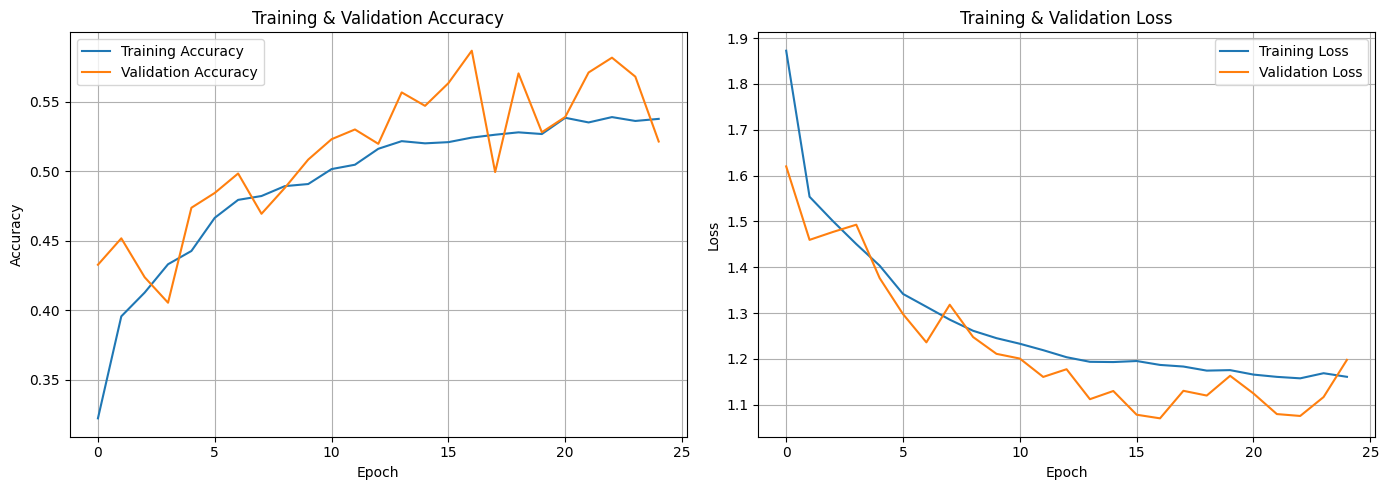

In [13]:
import matplotlib.pyplot as plt

# =============================
# ✅ Plot Accuracy and Loss
# =============================
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call the function
plot_history(history)


rest

In [14]:
class AdamW(tf.keras.optimizers.Adam):
    def __init__(self, weight_decay=1e-4, **kwargs):
        super().__init__(**kwargs)
        self.weight_decay = weight_decay

    def _decay_weights_op(self, var):
        return var.assign_sub(self.weight_decay * self.lr * var, read_value=False)

    def apply_gradients(self, grads_and_vars, name=None, **kwargs):
        grads, vars = zip(*grads_and_vars)
        for var in vars:
            if 'bias' not in var.name and 'bn' not in var.name:
                self._decay_weights_op(var)
        return super().apply_gradients(grads_and_vars, name, **kwargs)


In [15]:
# =============================
# ✅ Compile Model
# =============================
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(0.001, decay_steps=10000)

ConvNeXt_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# =============================
# ✅ Callbacks
# =============================
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=8,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [16]:
# =============================
# ✅ Train the Model
# =============================
history = ConvNeXt_model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=50,
    validation_data=val_ds,
    callbacks=[early_stopping_cb, reduce_lr_cb]
)


Epoch 1/50
1755/1755 ━━━━━━━━━━━━━━━━━━━━ 444s 235ms/step - accuracy: 0.5178 - loss: 1.1941 - val_accuracy: 0.5733 - val_loss: 1.1156 - learning_rate: 9.2591e-04
Epoch 2/50
1755/1755 ━━━━━━━━━━━━━━━━━━━━ 407s 232ms/step - accuracy: 0.5505 - loss: 1.1446 - val_accuracy: 0.5843 - val_loss: 1.0764 - learning_rate: 7.2559e-04
Epoch 3/50
1755/1755 ━━━━━━━━━━━━━━━━━━━━ 407s 232ms/step - accuracy: 0.5578 - loss: 1.1175 - val_accuracy: 0.6060 - val_loss: 0.9943 - learning_rate: 4.5842e-04
Epoch 4/50
1755/1755 ━━━━━━━━━━━━━━━━━━━━ 407s 232ms/step - accuracy: 0.5795 - loss: 1.0644 - val_accuracy: 0.6303 - val_loss: 0.9638 - learning_rate: 2.0357e-04
Epoch 5/50
1755/1755 ━━━━━━━━━━━━━━━━━━━━ 407s 232ms/step - accuracy: 0.5980 - loss: 1.0297 - val_accuracy: 0.6427 - val_loss: 0.9471 - learning_rate: 3.6572e-05
Epoch 6/50
1755/1755 ━━━━━━━━━━━━━━━━━━━━ 408s 232ms/step - accuracy: 0.6157 - loss: 1.0068 - val_accuracy: 0.6437 - val_loss: 0.9378 - learning_rate: 0.0000e+00
Epoch 7/50
1755/1755 ━━━━━━━

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Regularization and augmentation parameters
weight_decay = 1e-4

# Data Augmentation Layer
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# ConvNeXt Block with L2 Regularization
class ConvNext_Block(tf.keras.Model):
    def __init__(self, dim, layer_scale_init_value=1e-6, **kwargs):
        super(ConvNext_Block, self).__init__(**kwargs)
        self.depthwise_convolution = layers.Conv2D(
            dim, kernel_size=7, padding="same", groups=dim,
            kernel_regularizer=tf.keras.regularizers.l2(weight_decay)
        )
        self.layer_normalization = layers.LayerNormalization(epsilon=1e-6)
        self.pointwise_convolution_1 = layers.Dense(
            4 * dim, kernel_regularizer=tf.keras.regularizers.l2(weight_decay)
        )
        self.GELU = layers.Activation("gelu")
        self.pointwise_convolution_2 = layers.Dense(
            dim, kernel_regularizer=tf.keras.regularizers.l2(weight_decay)
        )
        self.gamma = tf.Variable(layer_scale_init_value * tf.ones((dim,)))

    def call(self, inputs):
        x = self.depthwise_convolution(inputs)
        x = self.layer_normalization(x)
        x = self.pointwise_convolution_1(x)
        x = self.GELU(x)
        x = self.pointwise_convolution_2(x)
        x = self.gamma * x
        return inputs + x

# Patchify Stem
def patchify_stem(dims):
    return keras.Sequential([
        layers.Conv2D(
            dims[0], kernel_size=4, strides=4,
            kernel_regularizer=tf.keras.regularizers.l2(weight_decay)
        ),
        layers.LayerNormalization(epsilon=1e-6)
    ])

# Downsampling Layers
def spatial_downsampling(stem, dims, kernel_size, stride):
    ds_layers = [stem]
    for dim in dims[1:]:
        layer = keras.Sequential([
            layers.LayerNormalization(epsilon=1e-6),
            layers.Conv2D(
                dim, kernel_size=kernel_size, strides=stride,
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay)
            ),
        ])
        ds_layers.append(layer)
    return ds_layers

# ConvNeXt Stages
def ConvNext_Stages(dims, depths, layer_scale_init_value):
    stages = []
    for i in range(len(dims)):
        stage = keras.Sequential([
            ConvNext_Block(dim=dims[i], layer_scale_init_value=layer_scale_init_value)
            for _ in range(depths[i])
        ])
        stages.append(stage)
    return stages

# Model Parameters
layer_scale_init_value = 1e-6
dims = [96, 192, 384, 768]
depths = [3, 3, 9, 3]

# Input Layer
inputs = layers.Input((64, 64, 3))
x = data_augmentation(inputs)  # Apply data augmentation

# Backbone
stem = patchify_stem(dims)
downsampling = spatial_downsampling(stem, dims, kernel_size=2, stride=2)
stages = ConvNext_Stages(dims, depths, layer_scale_init_value)

for i in range(len(stages)):
    x = downsampling[i](x)
    x = stages[i](x)

# Head
x = layers.GlobalAvgPool2D()(x)
x = layers.LayerNormalization(epsilon=1e-6)(x)
x = layers.Dropout(0.3)(x)  # Dropout added
outputs = layers.Dense(6)(x)

# Final Model
ConvNeXt_model = keras.Model(inputs, outputs)

# Learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(0.001, 10000)

# Compile Model
ConvNeXt_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Early Stopping Callback
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

# Training
history = ConvNeXt_model.fit(
    train_ds,
    batch_size=64,
    epochs=25,
    validation_data=val_ds,
    callbacks=[early_stopping_cb]
)


Epoch 1/25


ValueError: Input 0 of layer "functional_19" is incompatible with the layer: expected shape=(None, 64, 64, 3), found shape=(None, 224, 224, 3)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class ConvNext_Block(tf.keras.Model):
    def __init__(self, dim, layer_scale_init_value=1e-6, **kwargs):
        super(ConvNext_Block, self).__init__(**kwargs)
        
        self.depthwise_convolution = layers.Conv2D(dim, kernel_size=7, padding="same", groups=dim)
        self.layer_normalization = layers.LayerNormalization(epsilon=1e-6)
        self.pointwise_convolution_1 = layers.Dense(4 * dim)
        self.GELU = layers.Activation("gelu")
        self.pointwise_convolution_2 = layers.Dense(dim)
        self.gamma = tf.Variable(layer_scale_init_value * tf.ones((dim,)))

    def call(self, inputs):
        x = self.depthwise_convolution(inputs)
        x = self.layer_normalization(x)
        x = self.pointwise_convolution_1(x)
        x = self.GELU(x)
        x = self.pointwise_convolution_2(x)
        x = self.gamma * x
        return inputs + x

def patchify_stem(dims):
    return keras.Sequential([
        layers.Conv2D(dims[0], kernel_size=4, strides=4),
        layers.LayerNormalization(epsilon=1e-6)
    ])

def spatial_downsampling(stem, dims, kernel_size, stride):
    ds_layers = [stem]
    for dim in dims[1:]:
        layer = keras.Sequential([
            layers.LayerNormalization(epsilon=1e-6),
            layers.Conv2D(dim, kernel_size=kernel_size, strides=stride),
        ])
        ds_layers.append(layer)
    return ds_layers

def ConvNext_Stages(dims, depths, layer_scale_init_value):
    stages = []
    for i in range(len(dims)):
        stage = keras.Sequential([
            ConvNext_Block(dim=dims[i], layer_scale_init_value=layer_scale_init_value)
            for _ in range(depths[i])
        ])
        stages.append(stage)
    return stages

# Model Parameters
layer_scale_init_value = 1e-6
dims = [96, 192, 384, 768]
depths = [3, 3, 9, 3]

inputs = layers.Input((64, 64, 3))

x = inputs

stem = patchify_stem(dims)
downsampling = spatial_downsampling(stem, dims, kernel_size=2, stride=2)
stages = ConvNext_Stages(dims, depths, layer_scale_init_value)

for i in range(len(stages)):
    x = downsampling[i](x)
    x = stages[i](x)

x = layers.GlobalAvgPool2D()(x)
x = layers.LayerNormalization(epsilon=1e-6)(x)
outputs = layers.Dense(6)(x)

ConvNeXt_model = keras.Model(inputs, outputs)

# Learning rate schedule (define if needed)
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(0.001, 10000)

ConvNeXt_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

history = ConvNeXt_model.fit(
    train_ds,
    batch_size=64,
    epochs=25,
    validation_data=val_ds
)


In [ ]:
class ConvNext_Block(tf.keras.Model):
    
    """
    Implementing the ConvNeXt block for 
    
    Args:
        dim: No of input channels
        drop_path: stotchastic depth rate 
        layer_scale_init_value=1e-6
    
    Returns:
        A conv block
    """
    
    def __init__(self, dim, drop_path=0.0, layer_scale_init_value=1e-6, **kwargs):
        super(ConvNext_Block, self).__init__(**kwargs)
        
        self.depthwise_convolution = layers.Conv2D(dim, kernel_size=7, padding="same", groups=dim )
        self.layer_normalization = layers.LayerNormalization(epsilon=1e-6)
        self.pointwise_convolution_1 = layers.Dense(4 * dim)
        self.GELU = layers.Activation("gelu")
        self.pointwise_convolution_2 = layers.Dense(dim)
        self.gamma = tf.Variable(layer_scale_init_value * tf.ones((dim,)))
        if drop_path>0.0:
            self.drop_path=(tfa.layers.StochasticDepth(drop_path))
        else:
            self.drop_path=layers.Activation("linear")
        

    def call(self, inputs):
        x = inputs
        x = self.depthwise_convolution(x)
        x = self.layer_normalization(x)
        x = self.pointwise_convolution_1(x)
        x = self.GELU(x)
        x = self.pointwise_convolution_2(x)
        x = self.gamma * x

        return inputs + self.drop_path(x)

In [ ]:
def patchify_stem(dims):
    """
    Implements the stem block of ConvNeXt
    
    Args:
        Dims: List of feature dimensions at each stage.
    
    Returns:
        feature maps after patchify operation
    """
    stem = keras.Sequential(
        [layers.Conv2D(dims[0], kernel_size=4, strides=4),
        layers.LayerNormalization(epsilon=1e-6)],
        )
    return stem

In [ ]:
def spatial_downsampling(stem,dims,kernel_size,stride):
    """
    Implements Spatial Downsampling of ConvNeXt
    
    Args:
        Dims: List of feature dimensions at each stage.
        stem: Patchify stem output of images
        kernel_size: Downsampling kernel_size
        stride: Downsampling stride length
    Returns:
        Downsampled layers
    """

    ds_layers = []
    ds_layers.append(stem)
    for dim in dims[1:]:
        layer = keras.Sequential(
            [layers.LayerNormalization(epsilon=1e-6),
            layers.Conv2D(dim, kernel_size=kernel_size, strides=stride),
            ]
        )
        ds_layers.append(layer)
        
    return ds_layers

In [ ]:
def ConvNext_Stages (dims,drop_path_rate,depths,layer_scale_init_value):
    """
    Creating stages each consiting of multiple residual blocks
    
    Args:
        dims: List of feature dimensions at each stage.
        drop_path_rate: Stochastic depth rate
        depths: Number of blocks at each stage
        layer_scale_init_value: Init value for Layer Scale
        
    """
    stages = []
    dropout_rates = [x for x in tf.linspace(0.0, drop_path_rate, sum(depths))]
    cur = 0
    for i in range(len(dims)):
        stage = keras.Sequential(
            [*[ConvNext_Block(dim=dims[i],drop_path=dropout_rates[cur + j],layer_scale_init_value=layer_scale_init_value) for j in range(depths[i])]
            ]
        )
        stages.append(stage)
        cur += depths[i]
    return stages

In [ ]:
drop_path_rate=0.0
layer_scale_init_value=1e-6
dims=[96, 192, 384, 768]
depths=[3, 3, 9, 3]

In [ ]:
inputs = layers.Input((32,32,3))
x = inputs

stem=patchify_stem(dims)

downsampling=spatial_downsampling(stem,dims,kernel_size=2,stride=2)

stages=ConvNext_Stages(dims,drop_path_rate,depths,layer_scale_init_value)

for i in range(len(stages)):
    x = downsampling[i](x)
    x = stages[i](x)

x = layers.GlobalAvgPool2D()(x)
x = layers.LayerNormalization(epsilon=1e-6)(x)

outputs = layers.Dense(10)(x)

ConvNeXt_model=keras.Model(inputs, outputs)

In [ ]:
ConvNeXt_model.summary()

In [ ]:
ConvNeXt_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

history=ConvNeXt_model.fit(train_data,
          batch_size=64,
          epochs=25,
          validation_data=test_data)

In [ ]:

x = StochasticDepth(survival_probability)(x, shortcut)


In [ ]:
class StochasticDepth(tf.keras.layers.Layer):
    def __init__(self, survival_prob=1.0):
        super(StochasticDepth, self).__init__()
        self.survival_prob = survival_prob

    def call(self, x, residual, training=False):
        if not training:
            return x + residual
        # During training, randomly drop the residual connection
        batch_size = tf.shape(x)[0]
        random_tensor = self.survival_prob + tf.random.uniform([batch_size, 1, 1, 1])
        binary_tensor = tf.floor(random_tensor)
        return tf.keras.layers.Add()([
            residual * binary_tensor / self.survival_prob,
            x
        ])


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class StochasticDepth(Layer):
    def __init__(self, drop_prob, **kwargs):
        super(StochasticDepth, self).__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, x, training=False):
        if not training or self.drop_prob == 0.0:
            return x

        # shape: [batch_size, 1, 1, 1]
        keep_prob = 1.0 - self.drop_prob
        batch_size = tf.shape(x)[0]
        random_tensor = keep_prob + tf.random.uniform([batch_size, 1, 1, 1], dtype=x.dtype)
        binary_tensor = tf.floor(random_tensor)
        return tf.divide(x, keep_prob) * binary_tensor  # rescale + mask

    def get_config(self):
        config = super(StochasticDepth, self).get_config()
        config.update({"drop_prob": self.drop_prob})
        return config
